# Определение температуры стали

<b>Задача:</b> Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая будет предсказывать температуру стали.

<b>Описание:</b> Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав, добавляя куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем сплав перемешивают и снова проводят измерения. Такой цикл повторяется до тех пор, пока не будет достигнут нужный химический состав сплава и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

---

In [1]:
# обработка данных
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# проверка статистических гипотез
from scipy.stats import norm

# обработка признаков
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# модели
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# нейронная сеть
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adamax, Adam, Adagrad, Adadelta

# поиск оптимальных гиперпараметров
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error

# построение графиков
%matplotlib inline
%config InlineBckend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = (16,7)

# ограничения и правила
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import warnings
warnings.filterwarnings('ignore')

np.random.seed(21)

In [2]:
# создадим словарь с информацией для подключения
data_base = { 'user': '***',
              'pwd': '***',
              'host': '***',
              'port': ***,
              'db': '***' }

# подключаемся к удаленной базе данных
connection = 'postgresql://{}:{}@{}:{}/{}'.format(
    data_base['user'], data_base['pwd'], data_base['host'], data_base['port'], data_base['db'])

engine = create_engine(connection)

---

## Предварительный анализ данных

In [3]:
# функция позволит формировать таблицы с данными для графиков без дублирования кода
def get_chart_data(data, column, plot_type):
    if plot_type.lower() == 'first_type':
        return data[column].value_counts().reset_index()
    elif plot_type.lower() == 'second_type':
        return data[column].dropna().astype(int).value_counts().reset_index()
    elif plot_type.lower() == 'third_type':
        return data[data[column] > 0][column]

In [4]:
# функция позволит строить barplot-график
def get_barplot_chart(chart_data, x_column, y_column, label_step, x_label, y_label, color):
    sns.barplot(data=chart_data, x=x_column, y=y_column, color=color)
    plt.xticks(np.arange(0, len(chart_data), label_step), rotation=90)
    plt.xlabel(x_label)
    plt.ylabel(y_label);

In [5]:
# функция позволит строить plot-график
def get_plot_chart(chart_data, rolling, color, x_label, y_label):
    chart_data.rolling(rolling).mean().plot(color=color)
    plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel(y_label);

### Электроды

In [6]:
# подключение к таблице с данными об электродах
query = ''' SELECT *
            FROM steel.data_arc; '''
arcs = pd.read_sql_query(query, con=engine); display(arcs)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,03:58:58,04:01:35,0.533670,0.354439
14872,3241,04:05:04,04:08:04,0.676604,0.523631
14873,3241,04:16:41,04:19:45,0.733899,0.475654
14874,3241,04:31:51,04:32:48,0.220694,0.145768


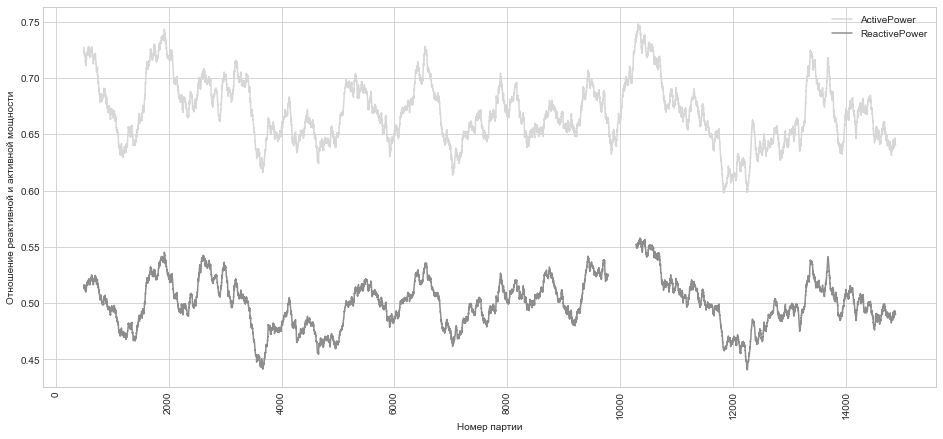

In [7]:
get_plot_chart(get_chart_data(arcs, ['ActivePower', 'ReactivePower'], 'third_type'), 500,
               ['#d7d7d7', '#8d8d8d'], 'Номер партии', 'Отношение реактивной и активной мощности')

<b>Комментарий:</b> На электроды интересно посмотреть в разрезе plot графика. Подобным методом хорошо видно, как активная мощность превосходит реактивную в среднем на 0.15, а в самой реактивной присутствуют отрицательные значения в районе 10.000 партии.

---

### Температура

In [8]:
# подключение к таблице с данными результатов измерения температуры
query = ''' SELECT *
            FROM steel.data_temp; '''
temp = pd.read_sql_query(query, con=engine); display(temp)

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
...,...,...,...
15902,3241,04:03:30,1586.0
15903,3241,04:16:12,NaN
15904,3241,04:22:39,NaN
15905,3241,04:33:42,NaN


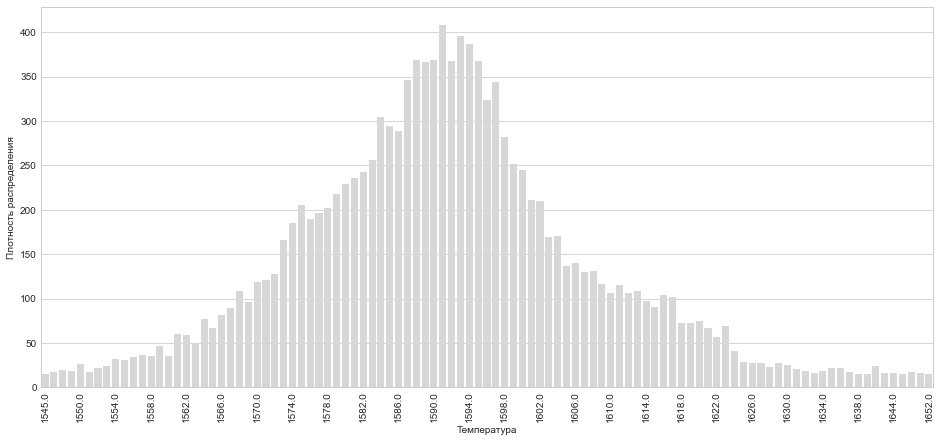

In [9]:
# распределение признака "температура"
get_barplot_chart(get_chart_data(temp, 'Temperature', 'first_type')[0:101], 'index', 'Temperature', 4,
                  'Температура', 'Плотность распределения', '#d7d7d7')

<b>Комментарий:</b> Насколько видно из графика, наше распределение симметрично-унимодальное. Исходя из этого, было бы интересно проверить, какой процент наблюдений превышает температуру в 1610 градусов. Для этого нам потребуется узнать стандартное отклонение выбранного признака и провести стандартизацию для интересующего порога.

$$\sigma = \sqrt D = \frac{\sum({x_i - \bar x)}^2}{n}$$

$$x_i' = \frac{x_i - \mu}{\sigma}$$

In [10]:
# стандартное отклонение (сигма)
def standard_deviation(data, ddof=0):
    return np.sqrt(((data - data.mean()) ** 2).sum() / (len(data) - ddof))

# стандартизация
def standard_scaler(data):
    return (threshold - data.mean()) / standard_deviation(data)

In [11]:
# порог
threshold = 1610

# стандартизация
scale = np.round(standard_scaler(temp['Temperature'].dropna()), 2)
# процент
percent = np.round(1 - norm.cdf(scale), 4)

print(f'Стандартизированный порог: {scale}\nПроцентов превышающих порог: {percent}')

Стандартизированный порог: 0.85
Процентов превышающих порог: 0.1977


<b>Комментарий:</b> Стандартизировав порог, можно было обратиться к специальной таблице, которая бы сказала, какой процент значений превышает выбранный порог, но в библиотеки Scipy существует специальный метод, который выдает нужное значение без таблицы.

В итоге, мы узнали, что всего ~20% превышают значение температуры в 1610 градусов при среднем 1592.

---

### Газ

In [12]:
# подключение к таблице с данными о продувке сплава газом
query = ''' SELECT *
            FROM steel.data_gas; '''
gas = pd.read_sql_query(query, con=engine); display(gas)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


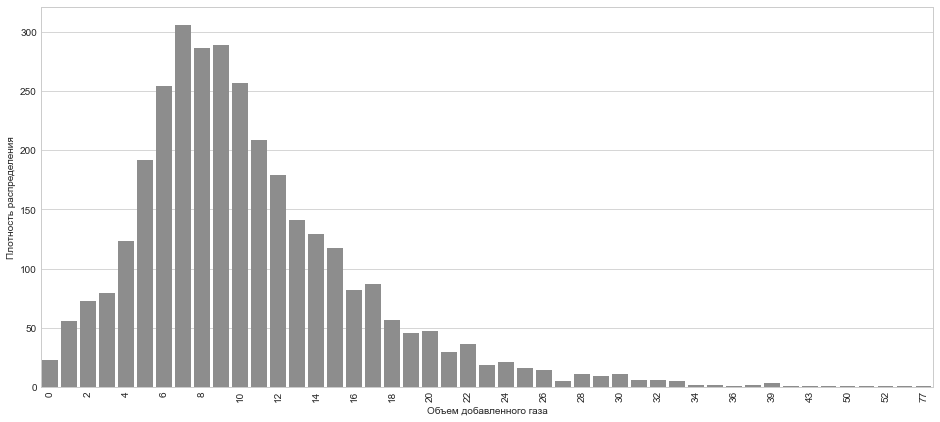

In [13]:
# распределение признака "газ"
get_barplot_chart(get_chart_data(gas, 'gas', 'second_type'), 'index', 'gas', 2,
                  'Объем добавленного газа', 'Плотность распределения', '#8d8d8d')

<b>Комментарий:</b> Данные по газу ассиметрично-унимодальные со смещением влево. Мода равна 7, а среднее 11. Некоторые данные явно выходят за пределы трех стандартных отклонений, поэтому нам придётся их удалить.

---

### Проволочные материалы

In [14]:
# подключение к таблице с данными о подаче проволочных материалах (объём)
query = ''' SELECT *
            FROM steel.data_wire; '''
wire = pd.read_sql_query(query, con=engine); display(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


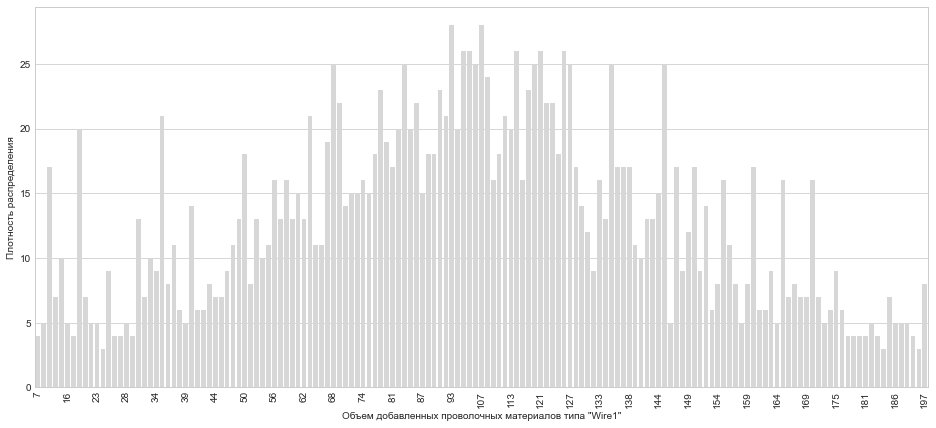

In [15]:
# распределение признака "проволочные материалы"
get_barplot_chart(get_chart_data(wire, 'Wire 1', 'second_type')[25:176], 'index', 'Wire 1', 5,
                  'Объем добавленных проволочных материалов типа "Wire1"', 'Плотность распределения', '#d7d7d7')

<b>Комментарий:</b> Как и во многих жизненных ситуациях, проволочные материалы имеют нормальное распределение. Но важно заметить, что присутствует много партий с конкретным объемом добавленной присадки, а не случайным ее значением. Такое поведение может быть обусловлено расчётами компании.

---

### Сыпучие материалы

In [16]:
# подключение к таблице с данными о подаче сыпучих материалов (объём)
query = ''' SELECT *
            FROM steel.data_bulk; '''
bulk = pd.read_sql_query(query, con=engine); display(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


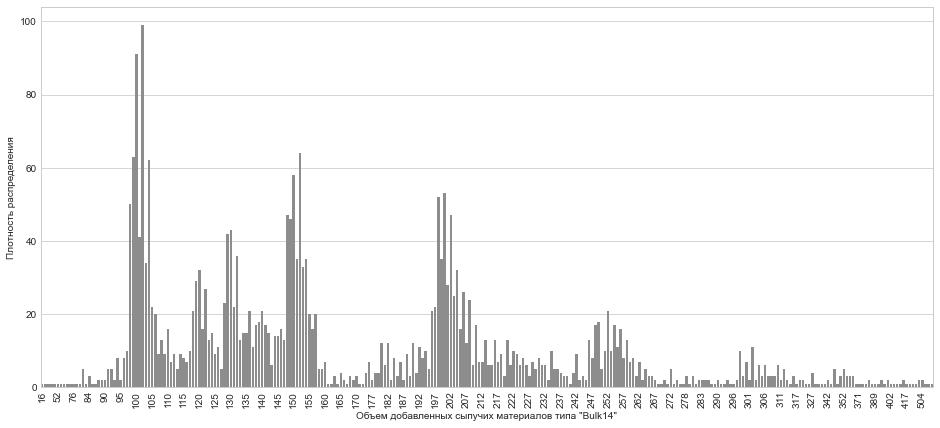

In [17]:
# распределение признака "газ"
get_barplot_chart(get_chart_data(bulk, 'Bulk 14', 'second_type'), 'index', 'Bulk 14', 5,
                  'Объем добавленных сыпучих материалов типа "Bulk14"', 'Плотность распределения', '#8d8d8d')

<b>Комментарий:</b> Дела с сыпучими материалами еще строже, чем с проволочными. Чаще всего добавляют 7 вариантов объема, которые характерно выделены на графике возрастающими пиками.

---

## Обработка данных

<b>Комментарий:</b> Переведем время в секунды, чтобы иметь возможность работать с числовыми признаками, а не временными рядами. В следующей стадии предобработки, мы сгенерируем несколько признаков на основе полученной информации.

In [18]:
# datatime.time -> seconds
def get_seconds(data) -> int:
    return (data.hour * 60 * 60) + (data.minute * 60) + data.second

# преобразуем три временных признака
arcs['BeginHeat'] = [get_seconds(time) for time in arcs['BeginHeat']]
arcs['EndHeat'] = [get_seconds(time) for time in arcs['EndHeat']]
temp['MesaureTime'] = [get_seconds(time) for time in temp['MesaureTime']]

<b>Комментарий:</b> Проведем соединение всех таблиц, чтобы иметь возможность удалить столбцы и признаки с пропусками, количество которых превышает выбранный нами порог. Удаление подобных признаков не только позволит ускорить обучаемость модели, но и акцентировать ее внимание на самых важных. Удаление же строк с пропусками, превышающими порог, увеличивает достоверность предсказаний.

In [19]:
# объединим данные, которые нуждаются в группировке. Столбец с последним измерением температуры станет - целевым
features = (arcs.groupby('key').mean().merge(temp.groupby('key').agg({'Temperature':['first' , 'last']}), how='inner', on='key'))

# переименуем столбцы
features = features.rename({features.columns[4]:'FirstTemp', features.columns[5]:'LastTemp'}, axis=1)

# объединим оставшиеся данные
features = features.merge(gas, on='key', how='inner').merge(wire, on='key', how='inner').merge(bulk, on='key', how='inner')

In [20]:
# удаление дефектных столбцов
features = features[features.columns[features.isna().mean() < 0.7]]
# удаление дефектных строк
features = features.loc[features.isnull().mean(axis=1) < 0.3]

features = features.fillna(0); display(features)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,FirstTemp,LastTemp,gas,Wire 1,Wire 2,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
0,1,40389.800000,40609.400000,0.975629,0.636648,1571.0,1613.0,29.749986,60.059998,0.00000,0.0,43.0,206.0,150.0,154.0
1,2,42137.750000,42340.500000,0.763150,0.499528,1581.0,1602.0,12.555561,96.052315,0.00000,0.0,73.0,206.0,149.0,154.0
2,3,44359.800000,44490.800000,0.505176,0.319815,1596.0,1599.0,28.554793,91.160157,0.00000,0.0,34.0,205.0,152.0,153.0
3,4,45987.500000,46172.750000,0.802313,0.515074,1601.0,1625.0,18.841219,89.063515,0.00000,0.0,81.0,207.0,153.0,154.0
4,5,48087.500000,48304.750000,0.836793,0.563161,1576.0,1602.0,5.413692,89.238236,9.11456,0.0,78.0,203.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,3237,82273.200000,82455.000000,0.786493,0.565692,1569.0,1569.0,5.543905,38.088959,0.00000,170.0,0.0,252.0,130.0,206.0
3018,3238,84739.666667,84921.666667,0.702176,0.560394,1584.0,1584.0,6.745669,56.128799,0.00000,126.0,0.0,254.0,108.0,106.0
3019,3239,6639.625000,6791.625000,0.583344,0.388952,1598.0,1598.0,16.023518,143.357761,0.00000,0.0,0.0,158.0,270.0,88.0
3020,3240,10911.600000,11079.400000,0.596817,0.496653,1617.0,1617.0,11.863103,34.070400,0.00000,0.0,0.0,0.0,192.0,54.0


<b>Комментарий:</b> После обработки данных, мы получили соединенный датасет с удаленными столбцами и строками, что облегчит нам дальнейшую работу с feature engineering, а также ускорит обучаемость модели. Заполнение же нулями говорит о том, что датчик данный датчик не измерял температуру в этой партии. Чем больше нулей встретит модель в каждой партии, тем хуже она предскажет целевую переменную. Именно поэтому мы провели обработку пропущенных значений.

---

<b>Комментарий:</b> Осталось обработать выбросы в данных, чтобы исключить критичные для моделей значения и можно приступать к генерации новых признаков.

In [21]:
def emissions_handling(data):
    upper = data.mean() + (data.std() * 3)
    lower = data.mean() - (data.std() * 3)
    
    return features[(data < upper) & (data > lower)]

for column in features.drop('key', axis=1):
    features = emissions_handling(features[column])

features = features.reset_index(drop=True)
print(f'Размерность после обработки выбросов: {features.shape[0]}')

Размерность после обработки выбросов: 2474


<b>Комментарий:</b> Данные были очищенны от выбросов, что позволит генерировать новые данные с уверенностью в их корректности.

---

## Feature Engineering

In [22]:
# найдем время нагрева "HeatingTime"
difference = []

for begin, end in zip(features['BeginHeat'], features['EndHeat']):
    if end >= begin:
        difference.append(end - begin)
    elif end < begin:
        difference.append((86400 - begin) + end)

features['HeatingTime'] = difference

In [23]:
# найдем время простоя "WaitingTime"
difference = []; difference.append(0)

for i in range(features.shape[0] - 1):
    if features['BeginHeat'][i+1] >= features['EndHeat'][i]:
        difference.append(features['BeginHeat'][i+1] - features['EndHeat'][i])
    elif features['BeginHeat'][i+1] < features['EndHeat'][i]:
        difference.append((86400 - features['EndHeat'][i]) + features['BeginHeat'][i+1])

features['WaitingTime'] = difference

# если простой свыше 6 часов, ставим 0 (начало новой смены)
features.loc[features['WaitingTime'] > 21600, 'WaitingTime'] = 0

In [24]:
# добавим среднее и сумму для признаков 'ActivePower' и 'ReactivePower'
features = features.merge(
    arcs.groupby('key').sum()[['ActivePower', 'ReactivePower']], on='key', how='left', suffixes=('Mean', 'Sum'))

# найдем среднее активной и реактивной мощности "MeanPower"
features['MeanPowerMean'] = (features['ActivePowerMean'] + features['ReactivePowerMean']) / 2
features['MeanPowerSum'] = (features['ActivePowerSum'] + features['ReactivePowerSum']) / 2

# найдем сумму активной и реактивной мощности "MeanPower"
features['SumPowerMean'] = (features['ActivePowerMean'] + features['ReactivePowerMean'])
features['SumPowerSum'] = (features['ActivePowerSum'] + features['ReactivePowerSum'])

# найдем разницу между активной и реактивной мощностью
features['DifferencePowerMean'] = (features['ActivePowerMean'] - features['ReactivePowerMean'])
features['DifferencePowerSum'] = (features['ActivePowerSum'] - features['ReactivePowerSum'])

# найдем полную мощность "FullPower"
features['FullPowerMean'] = np.sqrt(features['ActivePowerMean']**2 + features['ReactivePowerMean']**2)
features['FullPowerSum'] = np.sqrt(features['ActivePowerSum']**2 + features['ReactivePowerSum']**2)

<b>Комментарий:</b> Поскольку полная мощность может внести весомы вклад в итоговые показатели, рассчитаем ее по формуле: $S=\sqrt{P^{2}+Q^{2}}$, где P - активная мощность; Q - реактивная мощность; S - полная мощность. Также, были добавлены признаки средней и суммарной активной и реактивной мощности, что позволит выбрать лучший вариант для нашей модели.

In [25]:
# найдем количество измерений температуры "MeasureNumber"
arcs['MeasureNumber'] = 1; features = features.merge(arcs.groupby(['key']).sum()['MeasureNumber'], on='key')

# итоговая таблица
display(features)

,key,BeginHeat,EndHeat,ActivePowerMean,ReactivePowerMean,FirstTemp,LastTemp,gas,Wire 1,Wire 2,...,ReactivePowerSum,MeanPowerMean,MeanPowerSum,SumPowerMean,SumPowerSum,DifferencePowerMean,DifferencePowerSum,FullPowerMean,FullPowerSum,MeasureNumber
0,2,42137.750000,42340.500000,0.763150,0.499528,1581.0,1602.0,12.555561,96.052315,0.00000,...,1.998112,0.631339,2.525355,1.262677,5.050710,0.263622,1.054486,0.912099,3.648398,4
1,3,44359.800000,44490.800000,0.505176,0.319815,1596.0,1599.0,28.554793,91.160157,0.00000,...,1.599076,0.412496,2.062479,0.824992,4.124958,0.185361,0.926806,0.597900,2.989502,5
2,4,45987.500000,46172.750000,0.802313,0.515074,1601.0,1625.0,18.841219,89.063515,0.00000,...,2.060298,0.658693,2.634774,1.317387,5.269548,0.287238,1.148952,0.953419,3.813674,4
3,5,48087.500000,48304.750000,0.836793,0.563161,1576.0,1602.0,5.413692,89.238236,9.11456,...,2.252643,0.699977,2.799908,1.399954,5.599815,0.273633,1.094530,1.008649,4.034596,4
4,6,50134.750000,50372.750000,0.988777,0.672294,1543.0,1596.0,11.273392,99.109917,9.11456,...,2.689175,0.830535,3.322142,1.661071,6.644283,0.316483,1.265933,1.195683,4.782734,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,3237,82273.200000,82455.000000,0.786493,0.565692,1569.0,1569.0,5.543905,38.088959,0.00000,...,2.828459,0.676093,3.380463,1.352185,6.760926,0.220801,1.104007,0.968803,4.844014,5
2470,3238,84739.666667,84921.666667,0.702176,0.560394,1584.0,1584.0,6.745669,56.128799,0.00000,...,1.681182,0.631285,1.893856,1.262570,3.787711,0.141782,0.425346,0.898384,2.695151,3
2471,3239,6639.625000,6791.625000,0.583344,0.388952,1598.0,1598.0,16.023518,143.357761,0.00000,...,3.111617,0.486148,3.889186,0.972296,7.778372,0.194392,1.555137,0.701124,5.608989,8
2472,3240,10911.600000,11079.400000,0.596817,0.496653,1617.0,1617.0,11.863103,34.070400,0.00000,...,2.483267,0.546735,2.733675,1.093470,5.467350,0.100163,0.500816,0.776437,3.882186,5


<b>Комментарий:</b> Было сгенерированно много новых признаков. Какие-то из них станут весомыми, а какие-то прийдется удалить на следующей стадии.

---

## Feature Selection

In [26]:
# удалим партии, где присутствует всего одно измерение температуры
features = features[features['MeasureNumber'] > 1]; features = features.reset_index(drop=True)

# находим признаки, у которых корреляция с таргетом больше 0.05
features = features[features.columns[features.corr().abs()['LastTemp'] > 0.05]]

In [27]:
corr_matrix = features.corr().abs()

# выбираем верхний треугольник корреляционной матрицы
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# найдем индекс столбцов с корреляцией между собой больше 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# исключаем признаки
features = features.drop(to_drop, axis=1); display(features.drop(['key', 'LastTemp'], axis=1).head(3))

,ActivePowerMean,FirstTemp,gas,Wire 1,Wire 2,Bulk 3,Bulk 4,Bulk 12,Bulk 15,WaitingTime,ActivePowerSum,MeasureNumber
0,0.763150,1581.0,12.555561,96.052315,0.0,0.0,73.0,206.0,154.0,0.0,3.052598,4
1,0.505176,1596.0,28.554793,91.160157,0.0,0.0,34.0,205.0,153.0,2019.3,2.525882,5
2,0.802313,1601.0,18.841219,89.063515,0.0,0.0,81.0,207.0,154.0,1496.7,3.209250,4


<b>Комментарий:</b> После удаления признаков с низкой корреляций на таргет и высокой между собой, осталось 13 признаков. Интересно заметить, что многие признаки, которые были нами сгенерированны выше не вошли в итоговый датасет.

---

## Обучение

<b>Комментарий:</b> Поскольку мы избавились от выбросов, вместо робастного шкалирования, для корректного обучения древовидных моделей, необходимо применить стандартизацию, которая преобразует исходные данные к нулевому среднему и единичному стандартному отклонению. Целью стандартизации является обеспечение возможности корректного сравнения значений наблюдений, собранных одними и теми же методами, но в различных условиях.

$$x_i' = \frac{x_i - \mu}{\sigma}$$

In [28]:
# стандартизация для древовидных моделей
# разделим данные на тренировочную и обучающую выборки
features_standard = features.drop(['key', 'LastTemp'], axis=1)
target = features[['LastTemp']]

# делим на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features_standard, target, train_size=0.8, random_state=21, shuffle=True)

# стандартизируем данные
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

---

### RandomForestRegressor
#### GridSearch

```python
model = RandomForestRegressor(random_state=21)

parametrs = { 'n_estimators': [2900, 3200, 3500],
              'max_depth': [18, 20, 22],
              'max_features': [7, 8, 9]}

search = GridSearchCV( model, parametrs, cv=5, 
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1, verbose=True )

search.fit(features_train, target_train)

print(f'Лучший результат: {search.best_score_}')
print(f'Лучшие параметры: {search.best_params_}')
```

In [29]:
model = RandomForestRegressor(n_estimators=3200,
                              max_depth= 20,
                              max_features=10,
                              random_state=21)

model.fit(features_train, target_train)
predictions = model.predict(features_test)

mean_absolute_error(target_test, predictions)

7.475125891546349

<b>Комментарий:</b> Каждая модель имеет свои важные признаки. Как мы видим, для случайного леса особую важность сыграло первое измерение температуры. Подобный подход позволит передать компании информацию о самых важных признаках для построения модели, что снизит затраты на датчики внутри производства.

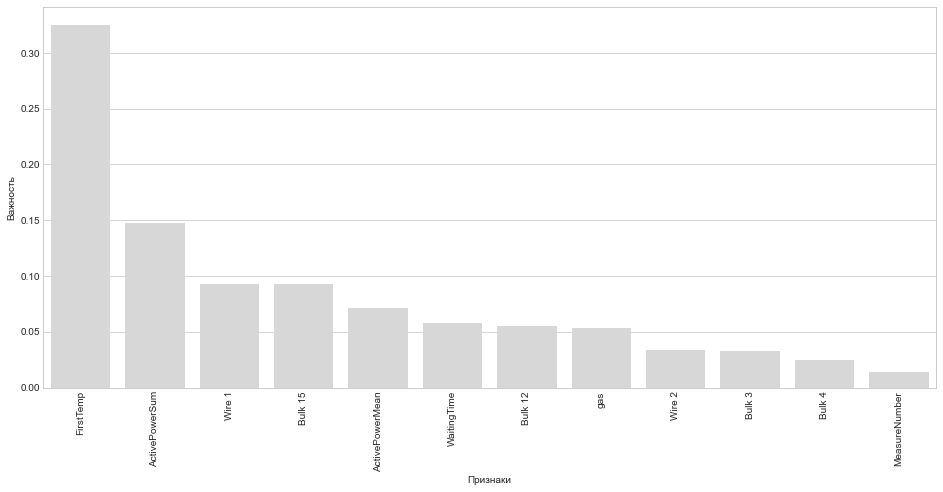

In [30]:
importance = {}
for feature, imp in zip(features.columns.drop(['key', 'LastTemp']), model.feature_importances_):
    importance[feature] = imp

importances = (pd.DataFrame.from_dict(importance, orient='index')
               .rename(columns={0: 'Gini-Importance'}).sort_values(by='Gini-Importance', ascending=False)
               .reset_index().rename(columns={'index': 'Features'}))

sns.barplot(data=importances, x='Features', y='Gini-Importance', color='#d7d7d7')
plt.xticks(rotation = 90)
plt.xlabel('Признаки')
plt.ylabel('Важность');

---

### CatBoostRegressor

<b>Комментарий:</b> В отличии от случайного леса, которому необходимо иметь большую глубину, градиентному бустингу этого не требуется. Его оптимальной глубиной является от 3 до 6. Это обусловлено иммитацией градиентного спуска за счет выского смещения и низкой дисперсии, которая получается как раз при такой глубине. Благодаря шагу сходимости, который мы можем задавать вручную, появляется возможность достичь быстрее достичь оптимума.

#### GridSearch

```python
model = CatBoostRegressor(loss_function='MAE', random_state=21)

parametrs = { 'max_depth': [3, 4, 5, 6],
              'n_estimators': [1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000],
              'learning_rate': [0.1, 0.01] }

search = GridSearchCV(model, parametrs, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=True)

search.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=False, plot=False)

print(f'Лучший результат: {search.best_score_}')
print(f'Лучшие параметры: {search.best_params_}')
```

In [31]:
# обучим лучшую модель на тесте
model = CatBoostRegressor(n_estimators=1900,
                          max_depth=6,
                          learning_rate=0.01,
                          loss_function='MAE',
                          random_state=21)

model.fit(features_train, target_train, verbose=False)
predictions = model.predict(features_test)

mean_absolute_error(target_test, predictions)

7.219352877104433

<b>Комментарий:</b> Как видно из графика, градиентный бустинг лишь немного изменил порядок важности конкретных признаков. Первичное измерение температуры все так же остается на первом месте.

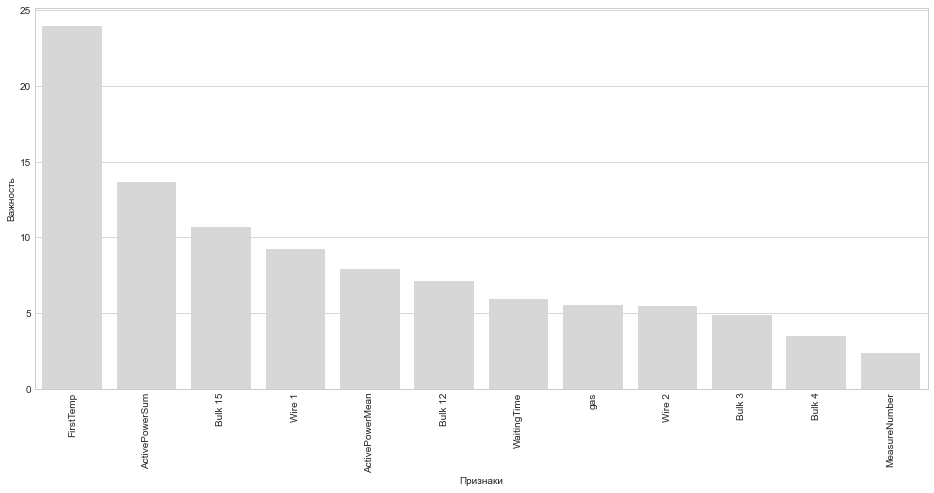

In [32]:
# найдем важность признаков
importance = {}
for feature, imp in zip(features.columns.drop(['key', 'LastTemp']), model.get_feature_importance()):
    importance[feature] = imp

importances = (pd.DataFrame.from_dict(importance, orient='index')
               .rename(columns={0: 'Gini-Importance'}).sort_values(by='Gini-Importance', ascending=False)
               .reset_index().rename(columns={'index': 'Features'}))

sns.barplot(data=importances, x='Features', y='Gini-Importance', color='#d7d7d7')
plt.xticks(rotation = 90)
plt.xlabel('Признаки')
plt.ylabel('Важность');

---

### Neural Network

<b>Комментарий:</b> Для нейронных сетей же, необходимо применить иной подход - шкалирование признаков от -1 до 1 или от 0 до 1. Данный метод позволяет избежать сразу же двух проблем: излишнее влияние признаков с большими значениями, а также позволит избавиться от перенасыщения, когда такие функции активации как сигмоидальная перестают корректировать веса из-за значений превышающих -1 и 1. Поскольку в нейронной сети планируется применение функции активации LeakyReLU, лучшим вариантом шкалирования будет от -1 до 1.

$$ x_{i} = \frac{x_{i}-x_{min}}{x_{max}-x_{min}} $$

$$LeakyReLU(x)=max(0.1⋅x,x)$$ 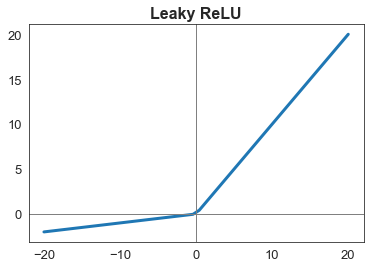

In [33]:
# шкалирование для Нейронной Сети
# разделим данные на тренировочную и обучающую выборки
features_min_max = features.drop(['key', 'LastTemp'], axis=1)
target = features[['LastTemp']]

# делим на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features_min_max, target, train_size=0.8, random_state=21, shuffle=True)

# прошкалируем данные
scaler = MinMaxScaler(feature_range=(-1, 1))
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

<b>Комментарий:</b> Поскольку решается задача регрессии, для корректных ответов в конце нейронной сети должен находиться один нейрон с линейной функцией активации, что позволит получать значения от минус бесконечности, до плюс бесконечности.

$$Linear(x)=k⋅x$$ 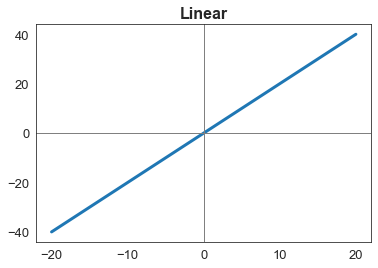

Критерием качества заказчиком был выбран MAE. Для эффективной его минимизации, лосс функцией выбран MSE, что позволит двигаться к цели в разы быстрее за счет квадрата. Подобный способ имеет и минусы, например: множество локальных минимумов или резкое возрастание при значимых ошибках.

$$E = \frac{1}{N} \sum^N_{i=1} |d_i - y_i|$$
$$E = \frac{1}{N} \sum^N_{i=1} (d_i - y_i)^2$$

Методом оптимизации чаще всего является Adam и его разновидности за счет крайне быстрого поиска глобального минимума в градиентном спуске. Adam использует сглаженные версии среднего $m$ и среднеквадратического $v$ градиента.

$$m_t = \beta_1m+(1-\beta_1)\cdot g_t \\ v_t=\beta_2+(1-\beta_2)\cdot g_t^2 \\ u_t=-\frac{\eta}{\sqrt{v+e}}\cdot m_t$$

#### GridSearch
```python
import telebot
bot = telebot.TeleBot(***)

def dimension_reduction(variance):
    return PCA(n_components=variance, whiten=True).fit_transform(features)

def neural_network():

    model = Sequential()
    model.add(Dense(units=1024, activation='relu', input_shape=(dimension_reduction(variance).shape[1],)))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='relu'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

# -----------------------------------------------------------------

model = KerasRegressor(model=neural_network, verbose=False)

params = {'optimizer' : ['adam', 'adamax'],
          'epochs' : [512, 1028, 2048],
          'batch_size' : [32, 64]}

grid = GridSearchCV(model, params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=False)

# -----------------------------------------------------------------

iteration = 0

for variance in [0.99, 0.98, 0.97, 0.96, 0.95]:
    grid.fit(dimension_reduction(variance), target)

    iteration+=1
    
    bot.send_message(***,
                     'Номер итерации: {}\n Оценка: {}\nДисперсия: {}\nРазмерность: {}\nПараметры: {}'.format(iteration,
                         grid.best_score_, variance, dimension_reduction(variance).shape[1], grid.best_params_));
```

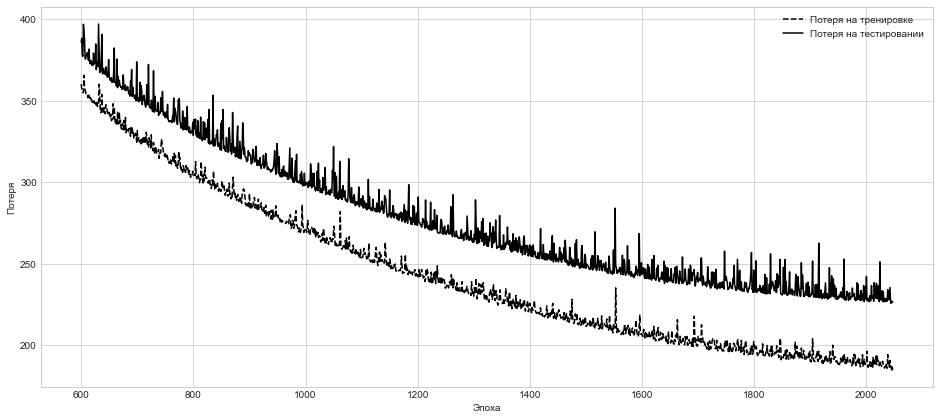

In [34]:
# спроектируем полносвязную нейронную сеть
model = Sequential()
model.add(Dense(units=1024, activation='LeakyReLU', input_shape=(features_train.shape[1],)))
model.add(Dense(units=512, activation='LeakyReLU', kernel_regularizer=regularizers.L1(0.01)))
model.add(Dense(units=64, activation='LeakyReLU', kernel_regularizer=regularizers.L1(0.01)))
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mse', optimizer=Adam(0.0001), metrics=['mae'])

history = model.fit(features_train, target_train, validation_split=0.4,
                    epochs=2048, batch_size=64, verbose=False)

# Получаем историю потерь
# Получаем историю потерь
training_loss = history.history['loss'][600:]
test_loss = history.history['val_loss'][600:]
epoch_count = range(600, len(training_loss) + 600)

# Визуализация истории потерь
plt.plot(epoch_count, training_loss, 'k--')
plt.plot(epoch_count, test_loss, 'k-')
plt.legend(['Потеря на тренировке', 'Потеря на тестировании'])
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show();

In [35]:
mean_absolute_error(target_test, model.predict(features_test))

16/16 [==============================] - 0s 1ms/step


7.787625140640847

---

<b>Вывод:</b> для корректного восприятия данных, был проведен анализ, проверена статистическая гипотеза и охарактеризованы распределения, после чего была проведена предобработка данных, где были исключены значения, привышающие три стандартных отклонения. Для повышения эффективности модели, было принято решение о генерации и отборе новых признаков. После отбора лучших из них, было произведено обучение моделей, где лучшей оказался градиентный бустинг с результатом 7.21, немного опережая другие модели.